# Import Libraries


In [90]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from IPython import display

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [91]:
# params_cfg = {
#     "action"  : "main_feat03",  
#     "seed"    : 42, # Set random seed
#     "exp_dir" : os.path.abspath('../../exps'),
#     'exp_name': 'featbase_22102025',
#     "data_dir": os.path.abspath("../../data/titanic"),
#     "verbose" : True,
# }
params_cfg = {
    "action"   : "train_feat03",  
    "feat_path": "../../exps/featbase_22102025/data.npz",
    "seed"    : 42, # Set random seed
    "exp_dir" : os.path.abspath('../../exps'),
    'exp_name': 'trainbase_22102025',
    "data_dir": os.path.abspath("../../../data"),
    "verbose" : True,
}
params_cfg.update(**{
    "save_dir": os.path.abspath(f'{params_cfg["exp_dir"]}/{params_cfg["exp_name"]}')
})

for v in params_cfg:
    print(f'+ {v}: {params_cfg[v]}')

globals().update(**params_cfg)

+ action: train_feat03
+ feat_path: ../../exps/featbase_22102025/data.npz
+ seed: 42
+ exp_dir: d:\dai_hoc\nam3\HK5\ML\LAB_GROUP\Challeng_1_Titanic_Final\process\exps
+ exp_name: trainbase_22102025
+ data_dir: d:\dai_hoc\nam3\HK5\ML\LAB_GROUP\Challeng_1_Titanic_Final\data
+ verbose: True
+ save_dir: d:\dai_hoc\nam3\HK5\ML\LAB_GROUP\Challeng_1_Titanic_Final\process\exps\trainbase_22102025


# Data Load


In [92]:
df_train = pd.read_csv(f'{data_dir}/train.csv')
df_test = pd.read_csv(f'{data_dir}/test.csv')

if params_cfg["verbose"]:
    print("-"*10, "information", "-"*10)
    print(f'train-col: {set(df_train.columns)}')
    print(f'test-col: {set(df_test.columns)}')
    print("Union:", set(df_train.columns).intersection(set(df_test.columns)))
    print("Difference:", set(df_train.columns).difference(set(df_test.columns)))

---------- information ----------
train-col: {'Name', 'PassengerId', 'SibSp', 'Cabin', 'Parch', 'Age', 'Sex', 'Fare', 'Survived', 'Embarked', 'Pclass', 'Ticket'}
test-col: {'Name', 'PassengerId', 'SibSp', 'Cabin', 'Parch', 'Age', 'Sex', 'Fare', 'Embarked', 'Pclass', 'Ticket'}
Union: {'Name', 'Cabin', 'PassengerId', 'SibSp', 'Parch', 'Age', 'Sex', 'Fare', 'Embarked', 'Pclass', 'Ticket'}
Difference: {'Survived'}


# Preprocessing


## Check missing value


In [93]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [94]:
df_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## Sex: giới tính


In [95]:
np.unique(df_train['Sex'].values)

array(['female', 'male'], dtype=object)

Nhận xét:

- Cột Sex là thuộc tính Category với 2 giới trị 'male' và 'female'
- Không có missing value
  => Ta sẽ mã hóa cột Sex dưới dạng số: "male" - 1 & "female" - 0


In [96]:
cls_sex = {'male': 1, 'female': 0}

In [97]:
df_output = pd.DataFrame()
df_output['Sex'] = df_train['Sex'].apply(lambda x: cls_sex[x])

## Age: Tuổi


In [98]:
np.unique(df_train['Age'].values)

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,
        5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  , 13.  ,
       14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 20.5 ,
       21.  , 22.  , 23.  , 23.5 , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 30.5 , 31.  , 32.  , 32.5 , 33.  ,
       34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  ,
       48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  , 55.5 ,
       56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 63.  , 64.  ,
       65.  , 66.  , 70.  , 70.5 , 71.  , 74.  , 80.  ,   nan])

<h2>Histogram phân bố độ tuổi và tỷ lệ sống sót


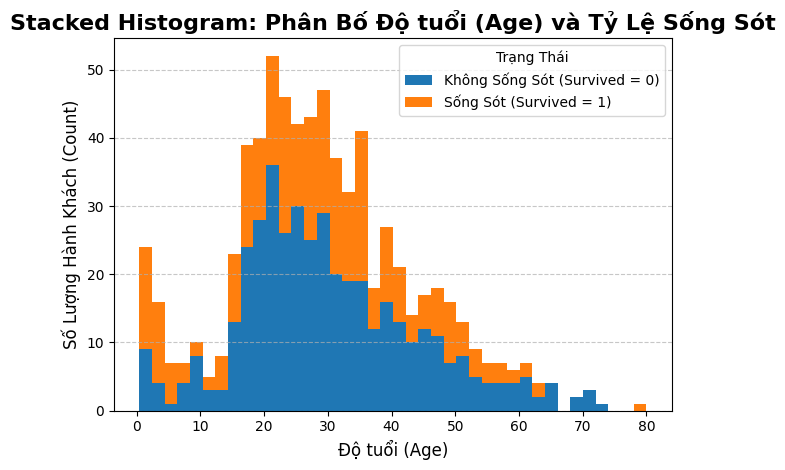

In [99]:
# pd.crosstab(index=df_train['Age'], columns = df_train['Survived'])
x_data1 = df_train[df_train['Survived'] == 0]['Age']
x_data2 = df_train[df_train['Survived'] == 1]['Age']
x_data = [x_data1, x_data2]
labels = ['Không Sống Sót (Survived = 0)', 'Sống Sót (Survived = 1)']
plt.hist(x_data, bins = 40, stacked=True, label=labels)
plt.title('Stacked Histogram: Phân Bố Độ tuổi (Age) và Tỷ Lệ Sống Sót', fontsize=16, fontweight='bold')
plt.xlabel('Độ tuổi (Age)', fontsize=12)
plt.ylabel('Số Lượng Hành Khách (Count)', fontsize=12)
plt.legend(loc='upper right', title="Trạng Thái")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

-> Ta có thể chia vé với bins=[-1,12,22,34,46,64,100]


In [100]:
df_output["Age"] = df_train["Age"].fillna(df_train["Age"].median())

In [101]:
# Cắt các giá trị theo khoảng và gắn labels
df_output['Age'] = pd.cut(df_output['Age'], bins=[-1,12,22,34,46,64,100], labels=['Babi', 'Teen', 'Young', 'Adult', 'Mid_Age', 'Old'])

In [102]:
cls_age = {'Babi':0, 'Teen':1, 'Young':2, 'Adult':3, 'Mid_Age':4, 'Old':5}

In [103]:
df_output['Age'] = df_output['Age'].apply(lambda x: cls_age[x])

## Fare: Giá vé


In [104]:
np.unique(df_train['Fare'].values)

array([  0.    ,   4.0125,   5.    ,   6.2375,   6.4375,   6.45  ,
         6.4958,   6.75  ,   6.8583,   6.95  ,   6.975 ,   7.0458,
         7.05  ,   7.0542,   7.125 ,   7.1417,   7.225 ,   7.2292,
         7.25  ,   7.3125,   7.4958,   7.5208,   7.55  ,   7.6292,
         7.65  ,   7.725 ,   7.7292,   7.7333,   7.7375,   7.7417,
         7.75  ,   7.775 ,   7.7875,   7.7958,   7.8   ,   7.8292,
         7.8542,   7.875 ,   7.8792,   7.8875,   7.8958,   7.925 ,
         8.0292,   8.05  ,   8.1125,   8.1375,   8.1583,   8.3   ,
         8.3625,   8.4042,   8.4333,   8.4583,   8.5167,   8.6542,
         8.6625,   8.6833,   8.7125,   8.85  ,   9.    ,   9.2167,
         9.225 ,   9.35  ,   9.475 ,   9.4833,   9.5   ,   9.5875,
         9.825 ,   9.8375,   9.8417,   9.8458,  10.1708,  10.4625,
        10.5   ,  10.5167,  11.1333,  11.2417,  11.5   ,  12.    ,
        12.275 ,  12.2875,  12.35  ,  12.475 ,  12.525 ,  12.65  ,
        12.875 ,  13.    ,  13.4167,  13.5   ,  13.7917,  13.8

<h2>Histogram phân bố giá vé và tỷ lệ sống sót


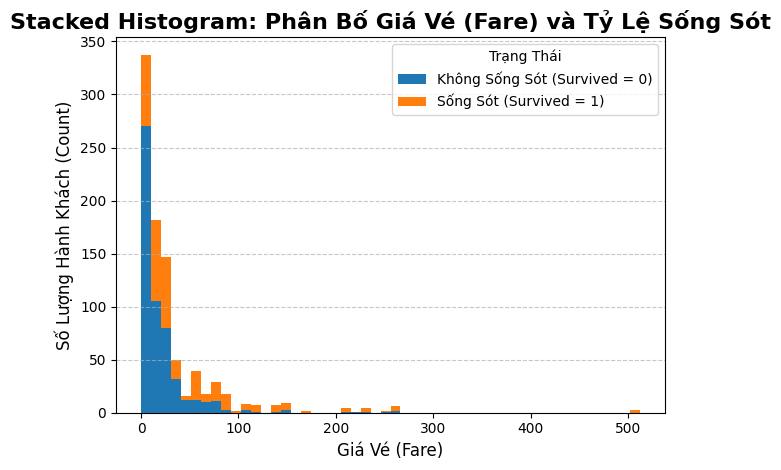

In [105]:
# pd.crosstab(index=df_train['Fare'], columns = df_train['Survived'])
x_data1 = df_train[df_train['Survived'] == 0]['Fare']
x_data2 = df_train[df_train['Survived'] == 1]['Fare']
x_data = [x_data1, x_data2]
labels = ['Không Sống Sót (Survived = 0)', 'Sống Sót (Survived = 1)']
plt.hist(x_data, bins = 50, stacked=True, label=labels)
plt.title('Stacked Histogram: Phân Bố Giá Vé (Fare) và Tỷ Lệ Sống Sót', fontsize=16, fontweight='bold')
plt.xlabel('Giá Vé (Fare)', fontsize=12)
plt.ylabel('Số Lượng Hành Khách (Count)', fontsize=12)
plt.legend(loc='upper right', title="Trạng Thái")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

-> Ta có thể chia vé với bins=[-1,40,80,200,1000]


In [106]:
# Cắt các giá trị theo khoảng và gắn labels
df_output['Fare'] = pd.cut(df_train['Fare'], bins=[-1,40,80,200,1000], labels=['So_Cheap', 'Cheap', 'Medium', 'Expensive'])

In [107]:
cls_fare = {'So_Cheap':1, 'Cheap':2, 'Medium':3, 'Expensive':4}

In [108]:
df_output['Fare'] = df_output['Fare'].apply(lambda x: cls_fare[x])

## Pclass: Hạng


In [109]:
np.unique(df_train['Pclass'].values)

array([1, 2, 3])

Nhận xét:

- Cột Pclass là thuộc tính Category gồm các giá trị số 1 2 3
- Không có missing value
  => Ta sẽ tạm thời giữ nguyên cột này


## Cabin: Tên cabin


In [110]:
np.unique(df_train['Cabin'].dropna().values)

array(['A10', 'A14', 'A16', 'A19', 'A20', 'A23', 'A24', 'A26', 'A31',
       'A32', 'A34', 'A36', 'A5', 'A6', 'A7', 'B101', 'B102', 'B18',
       'B19', 'B20', 'B22', 'B28', 'B3', 'B30', 'B35', 'B37', 'B38',
       'B39', 'B4', 'B41', 'B42', 'B49', 'B5', 'B50', 'B51 B53 B55',
       'B57 B59 B63 B66', 'B58 B60', 'B69', 'B71', 'B73', 'B77', 'B78',
       'B79', 'B80', 'B82 B84', 'B86', 'B94', 'B96 B98', 'C101', 'C103',
       'C104', 'C106', 'C110', 'C111', 'C118', 'C123', 'C124', 'C125',
       'C126', 'C128', 'C148', 'C2', 'C22 C26', 'C23 C25 C27', 'C30',
       'C32', 'C45', 'C46', 'C47', 'C49', 'C50', 'C52', 'C54', 'C62 C64',
       'C65', 'C68', 'C7', 'C70', 'C78', 'C82', 'C83', 'C85', 'C86',
       'C87', 'C90', 'C91', 'C92', 'C93', 'C95', 'C99', 'D', 'D10 D12',
       'D11', 'D15', 'D17', 'D19', 'D20', 'D21', 'D26', 'D28', 'D30',
       'D33', 'D35', 'D36', 'D37', 'D45', 'D46', 'D47', 'D48', 'D49',
       'D50', 'D56', 'D6', 'D7', 'D9', 'E10', 'E101', 'E12', 'E121',
       'E17',

Nhận xét:

- Cột Cabin là thuộc tính dạng String
- Có rất nhiều missing value
  => Ta sẽ drop cột này khỏi tập feature vì khó xử lý


## Embarked: Cảng


In [111]:
np.unique(df_train['Embarked'].dropna().values)

array(['C', 'Q', 'S'], dtype=object)

Nhận xét:

- Cột Embarked là thuộc tính Category gồm các giá trị C, Q, S
- Không có missing value
  => Ta sẽ fillna bằng giá trị mode và mã hóa cột Embarked dưới dạng số: "C": 1, "Q": 2, "S": 3


In [112]:
cls_embarked = {'C': 1, 'Q': 2, 'S': 3}

In [113]:
df_output['Embarked'] = df_train['Embarked'].fillna(df_train['Embarked'].mode()[0]).apply(lambda x: cls_embarked[x])

## Name: Tên hành khách


In [114]:
np.unique(df_train['Name'].dropna().values)

array(['Abbing, Mr. Anthony', 'Abbott, Mr. Rossmore Edward',
       'Abbott, Mrs. Stanton (Rosa Hunt)', 'Abelson, Mr. Samuel',
       'Abelson, Mrs. Samuel (Hannah Wizosky)',
       'Adahl, Mr. Mauritz Nils Martin', 'Adams, Mr. John',
       'Ahlin, Mrs. Johan (Johanna Persdotter Larsson)',
       'Aks, Mrs. Sam (Leah Rosen)', 'Albimona, Mr. Nassef Cassem',
       'Alexander, Mr. William', 'Alhomaki, Mr. Ilmari Rudolf',
       'Ali, Mr. Ahmed', 'Ali, Mr. William',
       'Allen, Miss. Elisabeth Walton', 'Allen, Mr. William Henry',
       'Allison, Master. Hudson Trevor', 'Allison, Miss. Helen Loraine',
       'Allison, Mrs. Hudson J C (Bessie Waldo Daniels)',
       'Allum, Mr. Owen George',
       'Andersen-Jensen, Miss. Carla Christine Nielsine',
       'Anderson, Mr. Harry', 'Andersson, Master. Sigvard Harald Elias',
       'Andersson, Miss. Ebba Iris Alfrida',
       'Andersson, Miss. Ellis Anna Maria',
       'Andersson, Miss. Erna Alexandra',
       'Andersson, Miss. Ingeborg Con

Nhận xét:

- Cột Name là thuộc tính text
- Không có missing value
  => Ta sẽ trích xuất đại từ nhân xưng của Name


In [115]:
def extract_name(x):
    return x.split(',')[1].split('.')[0].strip()

In [116]:
df_output['Name'] = df_train['Name'].apply(lambda x: extract_name(x))

In [117]:
np.unique(df_output['Name'])

array(['Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master',
       'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir',
       'the Countess'], dtype=object)

In [118]:
df_output['Name'].value_counts()

Name
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64

<h2>Chỉ lấy ra top 5 đại từ phổ biến


In [119]:
cls_name = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Dr': 5, 'Others': 6}

In [120]:
top_5_title = df_train['Name'].apply(lambda x: extract_name(x)).value_counts().head(5).index.tolist()

In [121]:
top_5_title

['Mr', 'Miss', 'Mrs', 'Master', 'Dr']

In [122]:
df_output['Name'] = df_train['Name'].apply(lambda x: cls_name[extract_name(x)] if extract_name(x) in top_5_title else cls_name['Others'])

In [123]:
df_output['Name'].value_counts()

Name
1    517
2    182
3    125
4     40
6     20
5      7
Name: count, dtype: int64

## SibSp: Anh chị em


In [124]:
np.unique(df_train['SibSp'].dropna().values)

array([0, 1, 2, 3, 4, 5, 8])

In [125]:
df_train['SibSp'].isna().sum()

np.int64(0)

Nhận xét:

- Cột SibSp là thuộc tính Category gồm các giá trị số: 0, 1, 2, 3, 4, 5, 8
- Không có missing value
  => Ta sẽ tạm thời giữ nguyên


## Parch: Ba mẹ, con cái


In [126]:
np.unique(df_train['Parch'].dropna().values)

array([0, 1, 2, 3, 4, 5, 6])

In [127]:
df_train['Parch'].isna().sum()

np.int64(0)

Nhận xét:

- Cột Parch là thuộc tính Category gồm các giá trị số: 0, 1, 2, 3, 4, 5, 6
- Không có missing value
  => Ta sẽ tạm thời giữ nguyên


<h2>Boy: Name = 'male' & Age < 16


<h2>Biểu đồ cột thể hiện tỷ lệ sống sót của nhóm Boy với nhóm còn lại


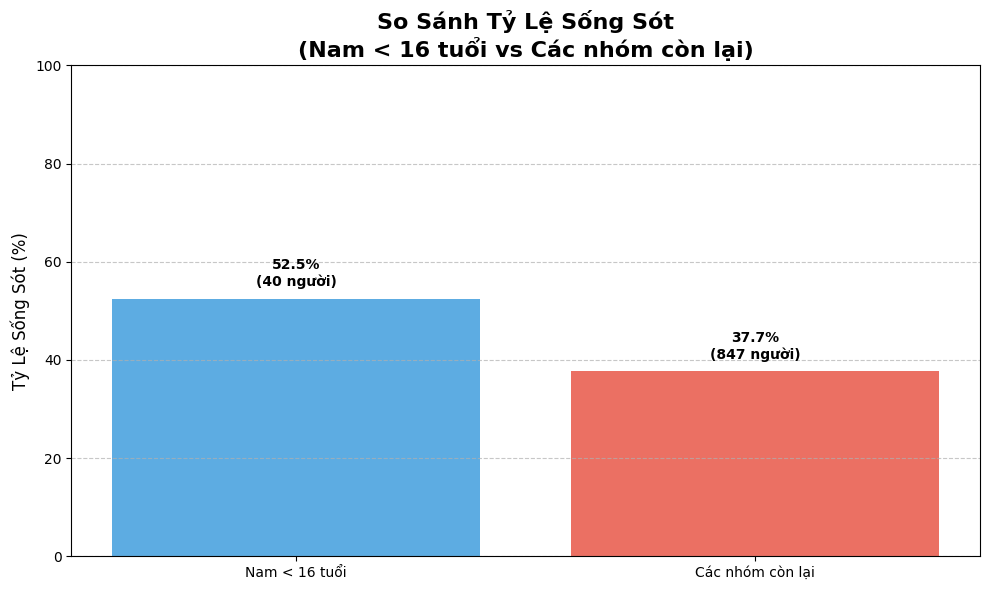

Tỷ lệ sống sót Nam < 16 tuổi: 52.50%
Tỷ lệ sống sót các nhóm còn lại: 37.66%


In [128]:
# Tạo nhóm dữ liệu
male_under_16 = df_train[(df_train['Sex'] == 'male') & (df_train['Age'] < 16)]
others = df_train[~((df_train['Sex'] == 'male') & ((df_train['Age'] < 16) | (df_train['Name'].apply(lambda x: extract_name(x)) == 'Master')))]

# Tính tỷ lệ sống sót cho từng nhóm
rate_male_under_16 = male_under_16['Survived'].mean() * 100
rate_others = others['Survived'].mean() * 100

# Tính số lượng cho từng nhóm
count_male_under_16 = len(male_under_16)
count_others = len(others)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
groups = ['Nam < 16 tuổi', 'Các nhóm còn lại']
rates = [rate_male_under_16, rate_others]
counts = [count_male_under_16, count_others]

bars = plt.bar(groups, rates, color=['#3498db', '#e74c3c'], alpha=0.8)

plt.title('So Sánh Tỷ Lệ Sống Sót\n(Nam < 16 tuổi vs Các nhóm còn lại)', 
          fontsize=16, fontweight='bold')
plt.ylabel('Tỷ Lệ Sống Sót (%)', fontsize=12)
plt.ylim(0, 100)

# Thêm số liệu lên cột
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{height:.1f}%\n({counts[i]} người)', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"Tỷ lệ sống sót Nam < 16 tuổi: {rate_male_under_16:.2f}%")
print(f"Tỷ lệ sống sót các nhóm còn lại: {rate_others:.2f}%")

In [129]:
def is_boy_row(row):
    return (row["Sex"] == "male") and ( pd.notna(row["Age"]) and row["Age"] < 16)

In [130]:
df_output["Boy"] = df_train.apply(is_boy_row, axis=1)

<h2> WomanOrBoy


<h2>Biểu đồ cột thể hiện tỷ lệ sống sót của nhóm Woman hoặc Boy với nhóm còn lại


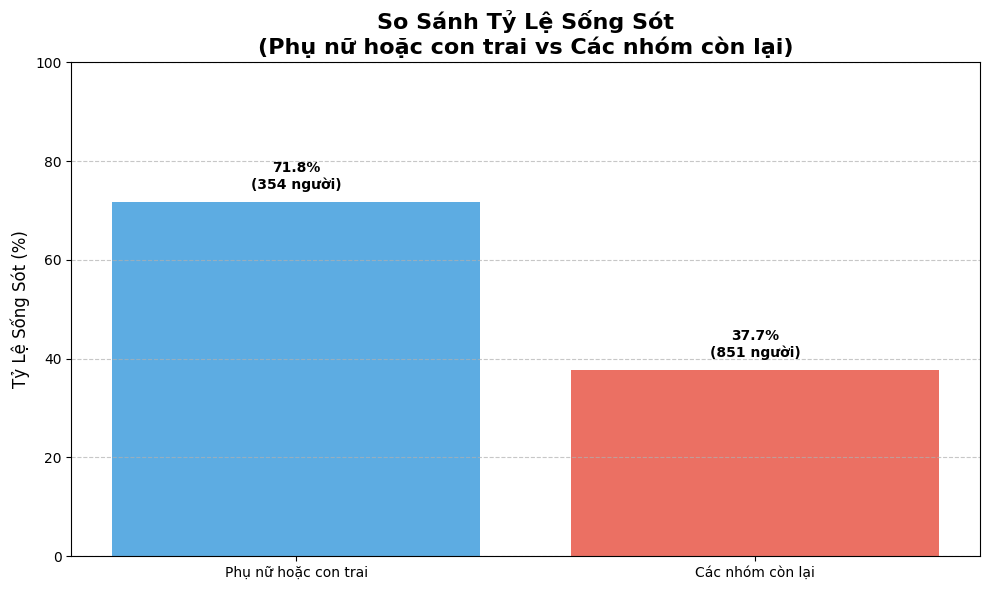

Tỷ lệ sống sót Phụ nữ hoặc con trai: 71.75%
Tỷ lệ sống sót các nhóm còn lại: 37.72%


In [134]:
# Tạo nhóm dữ liệu
woman_boy = df_train[((df_train['Sex'] == 'male') & (df_train['Age'] < 16)) | ((df_train['Sex'] == 'female'))]
others = df_train[~((df_train['Sex'] == 'male') & ((df_train['Age'] < 16))) | ((df_train['Sex'] == 'female'))]

# Tính tỷ lệ sống sót cho từng nhóm
rate_woman_boy = woman_boy['Survived'].mean() * 100
rate_others = others['Survived'].mean() * 100

# Tính số lượng cho từng nhóm
count_woman_boy = len(woman_boy)
count_others = len(others)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
groups = ['Phụ nữ hoặc con trai', 'Các nhóm còn lại']
rates = [rate_woman_boy, rate_others]
counts = [count_woman_boy, count_others]

bars = plt.bar(groups, rates, color=['#3498db', '#e74c3c'], alpha=0.8)

plt.title('So Sánh Tỷ Lệ Sống Sót\n(Phụ nữ hoặc con trai vs Các nhóm còn lại)', 
          fontsize=16, fontweight='bold')
plt.ylabel('Tỷ Lệ Sống Sót (%)', fontsize=12)
plt.ylim(0, 100)

# Thêm số liệu lên cột
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{height:.1f}%\n({counts[i]} người)', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"Tỷ lệ sống sót Phụ nữ hoặc con trai: {rate_woman_boy:.2f}%")
print(f"Tỷ lệ sống sót các nhóm còn lại: {rate_others:.2f}%")

-> Tỷ lệ sống sót nhóm này cao hơn hẳn những nhóm còn lại


In [131]:
df_output["WomanOrBoy"] = (df_output["Sex"] == 'female') | (df_output["Boy"])

In [132]:
def preprocessing_feature_01(df_data, is_train = True, is_debug = True, **kwargs):
    df_output = pd.DataFrame()

    # # Sex: gioi tinh
    # cls_sex = {'female': 0, 'male' : 1}
    # df_output["Sex"] = df_data["Sex"].apply(lambda x: cls_sex[x])
    # # Age: median
    # df_output["Age"] = df_data["Age"].fillna(df_data["Age"].median())
    # # Fare, Pclass
    # for name in ['Fare', 'Pclass', 'SibSp', 'Parch']:
    #     df_output[name] = df_data[name]
    # # Cabin
    # cls_cabin = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8, 'Z':0}
    # df_output["Cabin"] = df_data['Cabin'].apply(lambda x: cls_cabin['Z'] if pd.isna(x) else cls_cabin[x[0]])
    # # Embarked
    # cls_embarked = {'0': 0, 'C':1, 'Q':2, 'S':3}
    # df_output["Embarked"] =  df_data['Embarked'].apply(lambda x: cls_embarked['0'] if pd.isna(x) else cls_embarked[x])
    # # Surname
    # surnames = ['Capt.', 'Col.', 'Don.', 'Dr.', 'Jonkheer.', 'Lady.', 'Major.', 
    #         'Master.', 'Miss.', 'Mlle.', 'Mme.', 'Mr.', 'Mrs.', 'Ms.', 'Rev.', 'Sir.', 'the']
    # cls_surnames = dict(zip(surnames, range(len(surnames))))
    # df_output["Surname"] = df_data['Name'].apply(lambda x: cls_surnames[x.split(',')[1].split(' ')[1]])

    # Sex: gioi tinh
    df_output["Sex"] = df_data["Sex"].apply(lambda x: cls_sex[x])
    # Age: median
    df_data["Age"] = df_data["Age"].fillna(df_data["Age"].median())
    df_output['Age'] = pd.cut(df_data['Age'], bins=[-1,12,22,34,46,64,100], labels=['Babi', 'Teen', 'Young', 'Adult', 'Mid_Age', 'Old']).apply(lambda x: cls_age[x])
    # Fare
    df_data['Fare'] = df_data['Fare'].fillna(df_data['Fare'].median())
    df_output['Fare'] = pd.cut(df_data['Fare'], bins=[-1,40,80,200,1000], labels=['So_Cheap', 'Cheap', 'Medium', 'Expensive']).apply(lambda x: cls_fare[x])
    # Pclass, SibSp, Parch
    for name in ['Pclass', 'SibSp', 'Parch', 'PassengerId']:
        df_output[name] = df_data[name]
    # Cabin
    # Drop, không xử lý
    # Embarked
    cls_embarked = {'C':1, 'Q':2, 'S':3}
    df_output['Embarked'] = df_data['Embarked'].fillna(df_data['Embarked'].mode()[0]).apply(lambda x: cls_embarked[x])
    # Name
    df_output['Name'] = df_data['Name'].apply(lambda x: cls_name[extract_name(x)] if extract_name(x) in top_5_title else cls_name['Others'])
    # Boy
    df_output['Boy'] = df_data.apply(is_boy_row, axis=1).astype(int)
    # WomanOrBoy
    df_output['WomanOrBoy'] = ((df_output["Sex"] == 0) | (df_output["Boy"])).astype(int)
    # Dummies các cột category - SỬA LỖI 2: Xử lý đúng cách
    dummies_col = ['Name', 'Fare', 'Age']
    
    # Tạo DataFrame tạm để chứa dummies
    df_dummies = df_output.copy()
    
    for col in dummies_col:
        # Tạo dummy variables
        dummies = pd.get_dummies(df_output[col], prefix=col, drop_first=True).astype(int)
        # Xóa cột gốc
        df_dummies = df_dummies.drop(col, axis=1)
        # Thêm dummies vào DataFrame
        df_dummies = pd.concat([df_dummies, dummies], axis=1)
    
    df_output = df_dummies
    
    if is_train:
        df_output["Output"] = df_data["Survived"]

    if is_debug:
        print("head(5)")
        display.display(df_output.head(5))
        print("isna")
        display.display(df_output.isna().sum())
        print("Columns:", df_output.columns.tolist())
        print("Shape:", df_output.shape)

    return df_output, None
    pass

# df_train = pd.read_csv(f'{data_dir}/train.csv')
# preprocessing_feature_01(df_train)

# Train


# Main


In [133]:
# def main_feat03(**kwargs):
#     # load data
#     df_train = pd.read_csv(f'{data_dir}/train.csv')
#     df_test = pd.read_csv(f'{data_dir}/test.csv')
#     # preprocessing
#     df_output_train, _ = preprocessing_feature_01(df_train, is_train = True, is_debug = False)
#     df_output_test, _ = preprocessing_feature_01(df_test, is_train = False, is_debug = False)
    
#     # saving
#     os.makedirs(save_dir, exist_ok = True)
    
#     np.savez(f'{save_dir}/data.npz', train=df_output_train, test=df_output_test)

#     kwargs.get('global_cfg', {}).update(**locals())
#     pass

# if params_cfg["action"] == "train_feat03":
#     print("Runing ... [train_feat03]")
#     main_feat03(global_cfg = globals())

def main_feat03(**kwargs):
    # load data
    df_train = pd.read_csv(f'{data_dir}/train.csv')
    df_test = pd.read_csv(f'{data_dir}/test.csv')
    # preprocessing
    df_output_train, _ = preprocessing_feature_01(df_train, is_train=True, is_debug=False)
    df_output_test, _ = preprocessing_feature_01(df_test, is_train=False, is_debug=False)
    
    # saving
    os.makedirs(save_dir, exist_ok=True)
    
    # Lưu trực tiếp DataFrame objects (cần allow_pickle=True khi load)
    np.savez(f'{save_dir}/data.npz', 
             train_data=df_output_train.values,
             test_data=df_output_test.values,
             train_columns=df_output_train.columns.values,  # Lưu tên cột train
             test_columns=df_output_test.columns.values,
             allow_pickle=True)
    
    print("Đã lưu DataFrame với đầy đủ thông tin cột")

    kwargs.get('global_cfg', {}).update(**locals())

if params_cfg["action"] == "train_feat03":
    print("Runing ... [train_feat03]")
    main_feat03(global_cfg = globals())

Runing ... [train_feat03]
Đã lưu DataFrame với đầy đủ thông tin cột


# End
